In [ ]:
# --- Core Libraries ---
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
from tqdm.autonotebook import tqdm

# --- Sklearn Imports (FIXED) ---
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- PyTorch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

/tmp/ipython-input-2921579399.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Load data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='liac-arff')

# Converting label(string to integer)
y = y.astype(np.int64)

# Split data in first 60K and last 10K
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Flattening and Normalizing (same as your original)
X_train_flat = X_train.reshape(X_train.shape[0], 28*28) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], 28*28) / 255.0

print(f"Shape of flattened training data: {X_train_flat.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of flattened training data: (60000, 784)
Shape of training labels: (60000,)


# Load Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
BATCH_SIZE = 64

# We use the flat, normalized data
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_flat, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# --- Create TensorDatasets ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("PyTorch DataLoaders created successfully.")

PyTorch DataLoaders created successfully.


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Input: 784 features, Output: 10 classes
        #(30->20->10)
        self.layers = nn.Sequential(
            nn.Linear(784, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the model and move it to the GPU
model_mlp = MLP().to(device)
print(model_mlp)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


# Fit MLPClassifier
Let us train MLP classifier with 2 hidden layers having 30 and 20 neurons respectively

In [ ]:
# --- Hyperparameters ---
learning_rate = 0.001
num_epochs = 10

# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=learning_rate)# parameters are weights and biases

print("Starting MLP training...")
for epoch in range(num_epochs):
    model_mlp.train()  # Training model
    running_loss = 0.0


    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to the device (GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Forward pass
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} finished, Loss: {running_loss/len(train_loader):.4f}")#Average loss per batch

print("MLP training finished.")

Starting MLP training...


Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 finished, Loss: 0.4998


Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 finished, Loss: 0.2383


Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 finished, Loss: 0.1912


Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 finished, Loss: 0.1621


Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 finished, Loss: 0.1419


Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 finished, Loss: 0.1270


Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 finished, Loss: 0.1155


Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 finished, Loss: 0.1063


Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 finished, Loss: 0.0980


Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 finished, Loss: 0.0910
MLP training finished.


--- PyTorch MLP Performance ---
Accuracy: 0.9636

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.94      0.96      1032
           3       0.93      0.97      0.95      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.96      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.95      0.95      0.95       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Confusion Matrix:


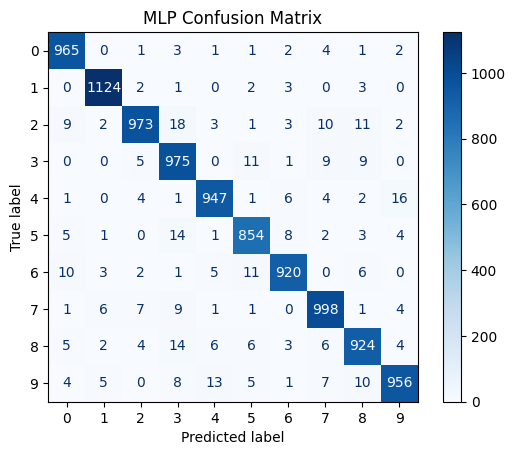

In [ ]:
model_mlp.eval()  # Set model to evaluation mode
y_pred_list = []
y_true_list = []

with torch.no_grad():  # Disable gradient calculations during testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_mlp(inputs)

        # Get the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Append batch results to lists
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for sklearn metrics
y_pred_mlp = np.array(y_pred_list)
y_true_mlp = np.array(y_true_list)

# --- Report MLP Performance ---
print("--- PyTorch MLP Performance ---")
mlp_accuracy = accuracy_score(y_true_mlp, y_pred_mlp)
print(f"Accuracy: {mlp_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_mlp, y_pred_mlp))

# --- Plot Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_mlp, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.show()

In [ ]:

print("Training Logistic Regression...")
# n_jobs=-1 uses all available CPU cores
# solver='saga' is good for large datasets like MNIST
# max_iter increased to 300 to ensure convergence
model_lr = LogisticRegression(solver='saga', n_jobs=-1, random_state=42, max_iter=300)
start_time = time.time()
model_lr.fit(X_train_flat, y_train)
print(f"Logistic Regression training time: {time.time() - start_time:.2f} seconds")



print("\nTraining Random Forest...")
# n_estimators=100 is a good default
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
start_time = time.time()
model_rf.fit(X_train_flat, y_train)
print(f"Random Forest training time: {time.time() - start_time:.2f} seconds")

print("\nBaseline models trained.")

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression training time: 583.37 seconds

Training Random Forest...
Random Forest training time: 34.19 seconds

Baseline models trained.


In [ ]:

y_pred_lr = model_lr.predict(X_test_flat)
y_pred_rf = model_rf.predict(X_test_flat)

#Evaluation metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
rf_accuracy = accuracy_score(y_test, y_pred_rf)


lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
mlp_f1 = f1_score(y_true_mlp, y_pred_mlp, average='weighted')

# --- Create a comparison table ---
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'MLP (PyTorch)'],
    'Accuracy': [lr_accuracy, rf_accuracy, mlp_accuracy],
    'F1-Score (Weighted)': [lr_f1, rf_f1, mlp_f1]
}
comparison_df = pd.DataFrame(comparison_data)

print("--- Model Comparison ---")
print(comparison_df.to_markdown(index=False))#index false cuz no index required

print("\n\n--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_lr))

print("\n\n--- Random Forest Report ---")
print(classification_report(y_test, y_pred_rf))

--- Model Comparison ---
| Model               |   Accuracy |   F1-Score (Weighted) |
|:--------------------|-----------:|----------------------:|
| Logistic Regression |     0.9254 |              0.925242 |
| Random Forest       |     0.9704 |              0.970372 |
| MLP (PyTorch)       |     0.9636 |              0.963588 |


--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                         

In [ ]:
# Create a new model to extract features from the 2nd hidden layer (20 neurons)
# We access the layers of your trained model by index
feature_extractor = nn.Sequential(
    *list(model_mlp.layers.children())[:-1] # Get all layers EXCEPT the last one (nn.Linear(20, 10))
).to(device)

# Ensure it's in evaluation mode
feature_extractor.eval()

print(feature_extractor)

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=20, bias=True)
  (3): ReLU()
)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

#t-SNE is slow so using 2000 samples
splitter = StratifiedShuffleSplit(n_splits=1, test_size=2000, random_state=42)
subset_indices, _ = next(splitter.split(X_test_flat, y_test))#stores the indices of the selected samples

#Extracting it from tensor
X_subset_tensor = X_test_tensor[subset_indices]
y_subset_labels = y_test[subset_indices]

print("Extracting trained embeddings...")
with torch.no_grad():
  #to obtain embeddings from 2nd hidden layer
    trained_embeddings = feature_extractor(X_subset_tensor.to(device))
# Move back to CPU as numpy arrays for sklearn
trained_embeddings = trained_embeddings.cpu().numpy()
print(f"Trained embeddings shape: {trained_embeddings.shape}")


# --- 2. Get UNTRAINED Embeddings ---
print("Extracting untrained embeddings...")
# Create a brand new, untrained model instance
untrained_mlp = MLP().to(device)
untrained_mlp.eval()

# Create an untrained feature extractor
untrained_feature_extractor = nn.Sequential(
    *list(untrained_mlp.layers.children())[:-1]
).to(device)

with torch.no_grad():
    untrained_embeddings = untrained_feature_extractor(X_subset_tensor.to(device))
untrained_embeddings = untrained_embeddings.cpu().numpy()
print(f"Untrained embeddings shape: {untrained_embeddings.shape}")

Extracting trained embeddings...
Trained embeddings shape: (8000, 20)
Extracting untrained embeddings...
Untrained embeddings shape: (8000, 20)


In [ ]:
from sklearn.manifold import TSNE

print("Running t-SNE for untrained model...")
tsne_untrained = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d_untrained = tsne_untrained.fit_transform(untrained_embeddings)

print("Running t-SNE for trained model...")
tsne_trained = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d_trained = tsne_trained.fit_transform(trained_embeddings)

print("t-SNE finished.")

Running t-SNE for untrained model...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE for trained model...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE finished.


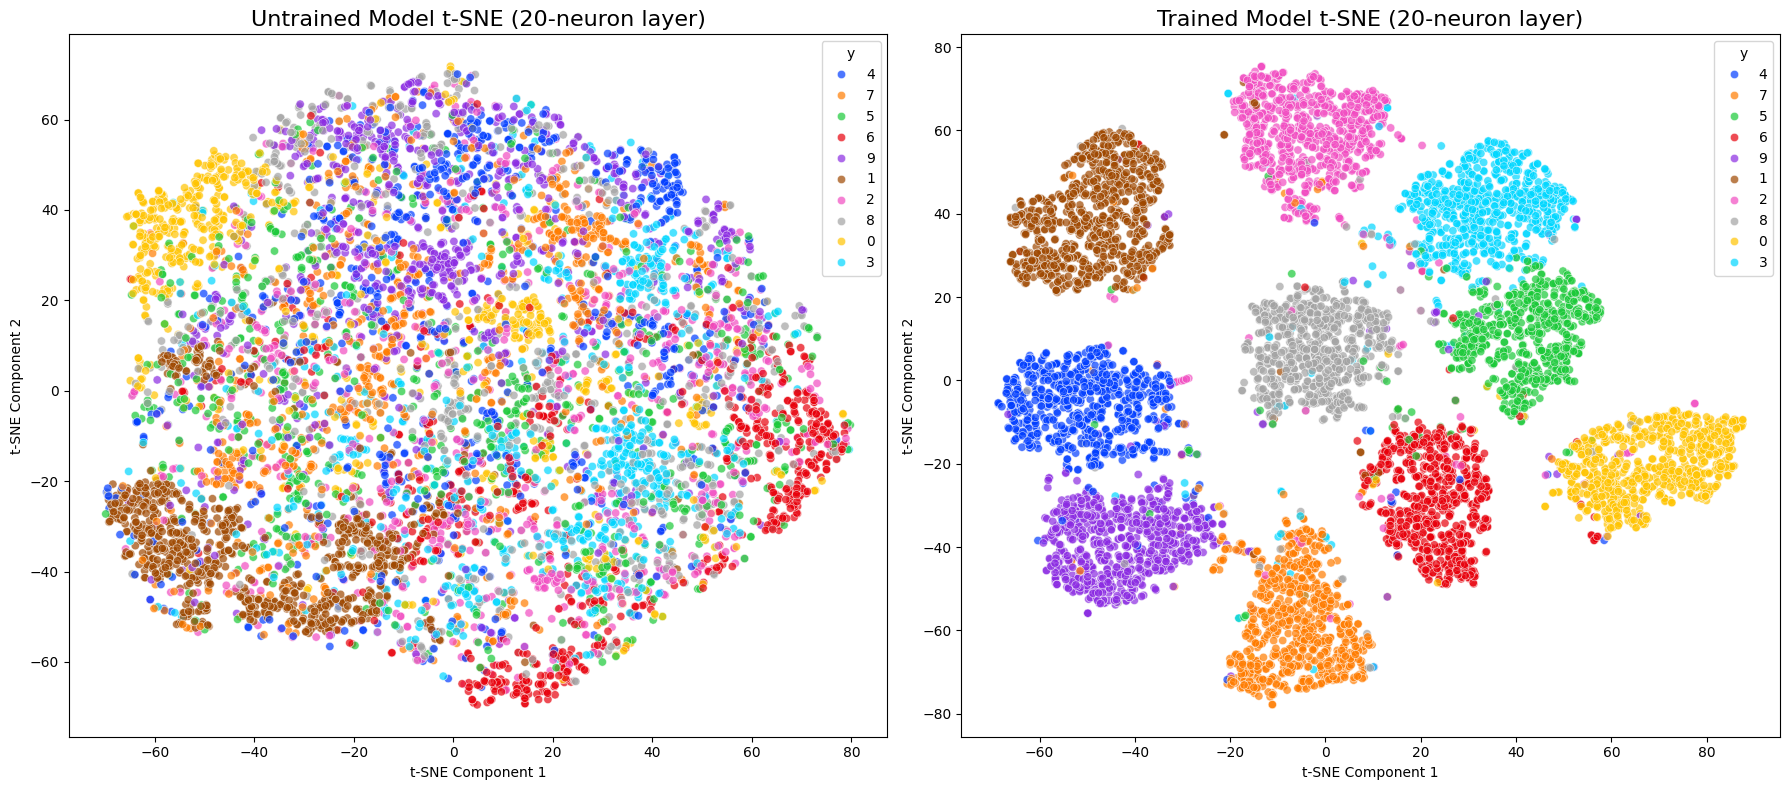

In [ ]:
# Create a DataFrame for easier plotting with seaborn
tsne_df = pd.DataFrame()
tsne_df['y'] = y_subset_labels.astype(str) # Convert labels to string for categorical coloring

# Add untrained data
tsne_df['x_untrained'] = embeddings_2d_untrained[:, 0]
tsne_df['y_untrained'] = embeddings_2d_untrained[:, 1]

# Add trained data
tsne_df['x_trained'] = embeddings_2d_trained[:, 0]
tsne_df['y_trained'] = embeddings_2d_trained[:, 1]


# --- Plotting ---
plt.figure(figsize=(18, 8))
palette = sns.color_palette("bright", 10)

# Plot 1: Untrained
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=tsne_df,
    x='x_untrained',
    y='y_untrained',
    hue='y',
    palette=palette,
    legend='full',
    alpha=0.7
)
plt.title("Untrained Model t-SNE (20-neuron layer)", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Plot 2: Trained
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=tsne_df,
    x='x_trained',
    y='y_trained',
    hue='y',
    palette=palette,
    legend='full',
    alpha=0.7
)
plt.title("Trained Model t-SNE (20-neuron layer)", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

In [ ]:
# --- FIX: Import torchvision ---
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print("Torchvision imported successfully.")

Torchvision imported successfully.


In [ ]:
# --- 1. Load Fashion-MNIST Test Dataset ---
# We don't need to train, so we only download the test set.
fashion_test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor() # Converts images to [0, 1] tensors
)

# --- 2. Preprocess and Create DataLoader ---
# We must preprocess it *exactly* like the original MNIST data:
# 1. Flatten the 28x28 images to 784
# 2. The ToTensor() transform already normalized to [0, 1]

# Get the raw test data and labels from the dataset
X_test_fashion = fashion_test_dataset.data.reshape(-1, 784).float() / 255.0
y_test_fashion = fashion_test_dataset.targets

# Create Tensors and DataLoader
fashion_test_tensor_dataset = TensorDataset(X_test_fashion, y_test_fashion)
fashion_test_loader = DataLoader(fashion_test_tensor_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Fashion-MNIST test data shape: {X_test_fashion.shape}")
print(f"Fashion-MNIST test labels shape: {y_test_fashion.shape}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]

Fashion-MNIST test data shape: torch.Size([10000, 784])
Fashion-MNIST test labels shape: torch.Size([10000])


In [ ]:
model_mlp.eval()  # Set model to evaluation mode
y_pred_list_fashion = []
y_true_list_fashion = []

with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in fashion_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Run the MNIST-trained model
        outputs = model_mlp(inputs)

        _, predicted = torch.max(outputs.data, 1)

        y_pred_list_fashion.extend(predicted.cpu().numpy())
        y_true_list_fashion.extend(labels.cpu().numpy())

# --- Report Fashion-MNIST Performance ---
fashion_accuracy = accuracy_score(y_true_list_fashion, y_pred_list_fashion)

print("--- MLP (Trained on Digits) Performance on Fashion-MNIST ---")
print(f"Accuracy: {fashion_accuracy * 100:.2f}%")
print("\nThis low accuracy is expected. It's close to random guessing (10%).")
print("It shows the model learned features *specific* to digits, not general images.")

print("\nClassification Report:")
print(classification_report(y_true_list_fashion, y_pred_list_fashion))

--- MLP (Trained on Digits) Performance on Fashion-MNIST ---
Accuracy: 11.46%

This low accuracy is expected. It's close to random guessing (10%).
It shows the model learned features *specific* to digits, not general images.

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.07      0.04      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.29      0.79      0.42      1000
           4       0.00      0.00      0.00      1000
           5       0.12      0.20      0.15      1000
           6       0.14      0.01      0.02      1000
           7       0.07      0.00      0.01      1000
           8       0.43      0.07      0.11      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.11     10000
   macro avg       0.11      0.11      0.08     10000
weighted avg       0.11      0.11      0.08    

In [ ]:
# We can re-use the 2000-sample subset indices from before
# Or create new ones if you prefer
X_subset_fashion = X_test_fashion[subset_indices]
y_subset_labels_fashion = y_test_fashion[subset_indices].numpy()

# Class names for Fashion-MNIST for the plot legend
fashion_labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}
y_subset_names_fashion = [fashion_labels_map[y] for y in y_subset_labels_fashion]


# --- Get Fashion-MNIST Embeddings (from MNIST-trained model) ---
print("Extracting Fashion-MNIST embeddings...")
with torch.no_grad():
    fashion_embeddings = feature_extractor(X_subset_fashion.to(device))
fashion_embeddings = fashion_embeddings.cpu().numpy()
print(f"Fashion-MNIST embeddings shape: {fashion_embeddings.shape}")

# --- Run t-SNE ---
print("Running t-SNE for Fashion-MNIST embeddings...")
tsne_fashion = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d_fashion = tsne_fashion.fit_transform(fashion_embeddings)
print("t-SNE finished.")

Extracting Fashion-MNIST embeddings...
Fashion-MNIST embeddings shape: (8000, 20)
Running t-SNE for Fashion-MNIST embeddings...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE finished.


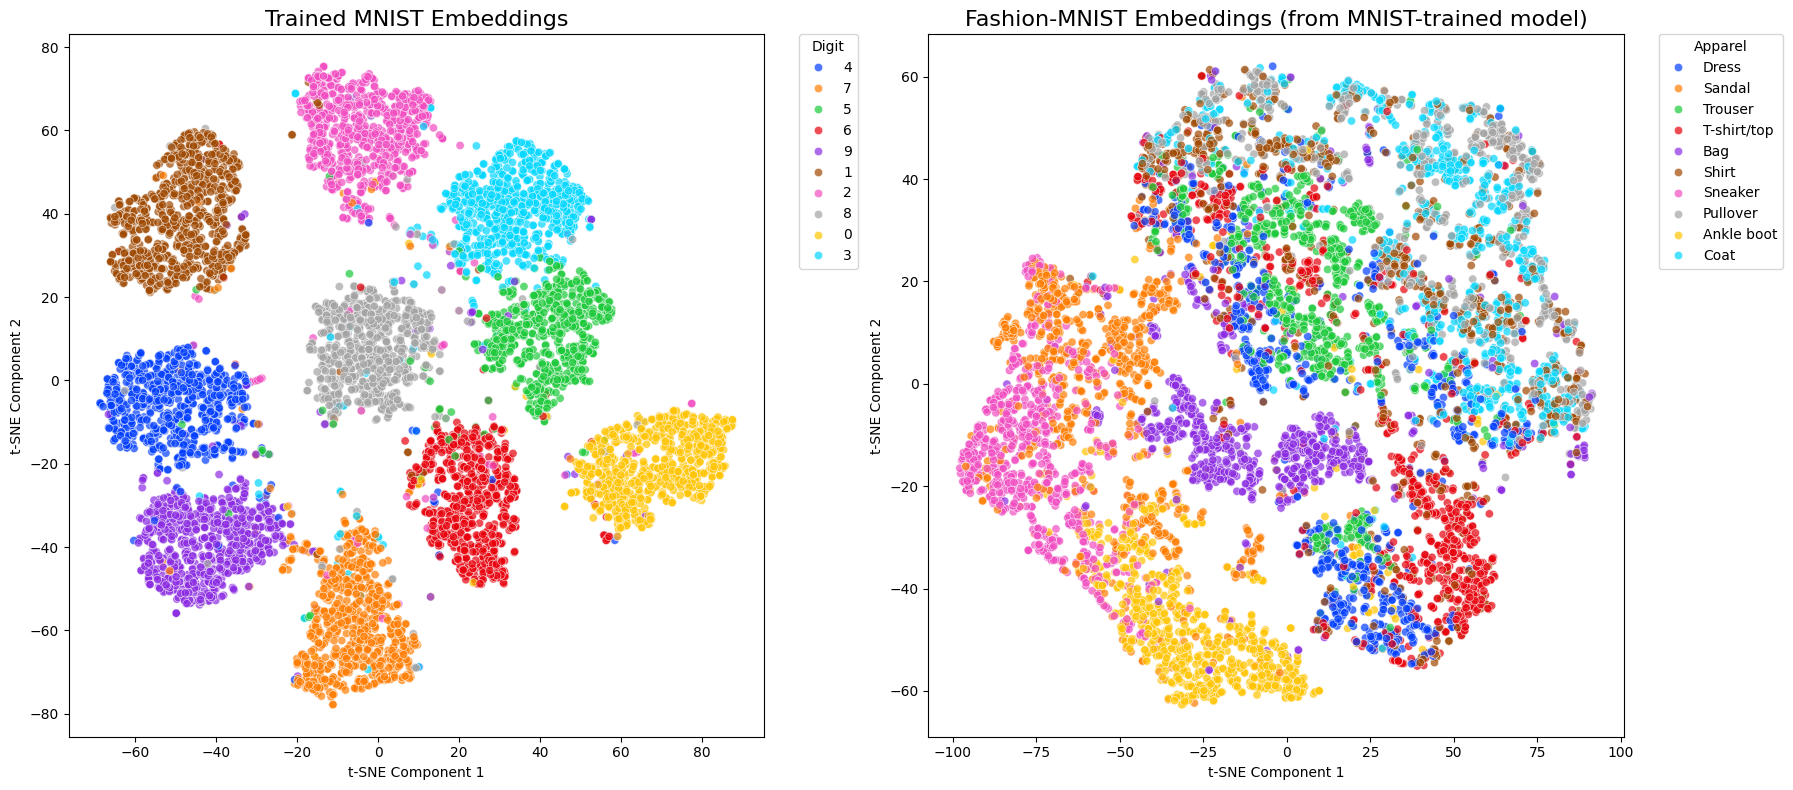

In [ ]:
# --- Create DataFrame for Fashion-MNIST Plotting ---
tsne_fashion_df = pd.DataFrame()
tsne_fashion_df['y_names'] = y_subset_names_fashion
tsne_fashion_df['x_fashion'] = embeddings_2d_fashion[:, 0]
tsne_fashion_df['y_fashion'] = embeddings_2d_fashion[:, 1]


# --- Plotting ---
plt.figure(figsize=(18, 8))
palette = sns.color_palette("bright", 10)

# Plot 1: Trained MNIST (from Cell 13)
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=tsne_df, # Re-using the DataFrame from Cell 13
    x='x_trained',
    y='y_trained',
    hue='y', # This is '0', '1', '2'...
    palette=palette,
    legend='full',
    alpha=0.7
)
plt.title("Trained MNIST Embeddings", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Digit", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Plot 2: Fashion-MNIST (from MNIST-trained model)
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=tsne_fashion_df,
    x='x_fashion',
    y='y_fashion',
    hue='y_names', # This is 'T-shirt', 'Trouser'...
    palette=palette,
    legend='full',
    alpha=0.7
)
plt.title("Fashion-MNIST Embeddings (from MNIST-trained model)", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Apparel", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
# --- Load MNIST data specifically for CNNs ---

# Define the transform:
# 1. ToTensor() - Converts PIL Image to a [0, 1] tensor
#                 AND changes shape from (H, W, C) to (C, H, W).
#                 For MNIST, it becomes [1, 28, 28].
# 2. Normalize() - Standardizes pixel values. (0.5, 0.5) is a common
#                  choice to shift the [0, 1] range to [-1, 1].
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Download Datasets ---
train_dataset_cnn = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_cnn
)

test_dataset_cnn = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_cnn
)

# --- Create DataLoaders ---
BATCH_SIZE = 64 # You can reuse the BATCH_SIZE variable

cnn_train_loader = DataLoader(
    dataset=train_dataset_cnn,
    batch_size=BATCH_SIZE,
    shuffle=True
)

cnn_test_loader = DataLoader(
    dataset=test_dataset_cnn,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("CNN DataLoaders created.")
# Let's check the shape of one batch
data, labels = next(iter(cnn_train_loader))
print(f"Data batch shape: {data.shape}")
print(f"Labels batch shape: {labels.shape}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]

CNN DataLoaders created.
Data batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Layer 1: Convolution + MaxPool
        # Input: [1, 28, 28] (Channel, Height, Width)
        # Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # Output: [32, 26, 26] (Kernel size 3 shrinks 28 to 26)
        # MaxPool2d(kernel_size=2, stride=2)
        # Output: [32, 13, 13] (Pool size 2 halves 26 to 13)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=0 # No padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer 2: Fully Connected (Dense) Layer
        # We must flatten the [32, 13, 13] output first.
        # Flattened size = 32 * 13 * 13 = 5408
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 13 * 13, 128),
            nn.ReLU()
        )

        # Layer 3: Output Layer
        self.output_layer = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.fc1(x)
        x = self.output_layer(x)
        return x

# --- Instantiate the model and move to GPU ---
model_cnn = SimpleCNN().to(device)
print(model_cnn)

# --- Optional: Check total parameters ---
from torchsummary import summary
# We need to install torchsummary first: !pip install torchsummary
summary(model_cnn, (1, 28, 28))

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=128, bias=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
           Flatten-4                 [-1, 5408]               0
            Linear-5                  [-1, 128]         692,352
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total par

In [ ]:
# --- Hyperparameters ---
learning_rate = 0.001
num_epochs = 10 # 10 epochs is usually enough for a CNN on MNIST

# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

# --- Training Loop ---
print("Starting Simple CNN training...")
for epoch in range(num_epochs):
    model_cnn.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(cnn_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to the device (GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Forward pass
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)

        # 2. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} finished, Loss: {running_loss/len(cnn_train_loader):.4f}")

print("CNN training finished.")

Starting Simple CNN training...


Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 finished, Loss: 0.1818


Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 finished, Loss: 0.0605


Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 finished, Loss: 0.0415


Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 finished, Loss: 0.0296


Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 finished, Loss: 0.0211


Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 finished, Loss: 0.0156


Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 finished, Loss: 0.0130


Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 finished, Loss: 0.0108


Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 finished, Loss: 0.0084


Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 finished, Loss: 0.0075
CNN training finished.


Simple CNN Inference Time: 1.8766 seconds

--- Simple CNN Performance ---
Accuracy: 0.9828
F1-Score (Weighted): 0.9828

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.97      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Model Size (Trainable Parameters): 693,962

Confusion Matrix:


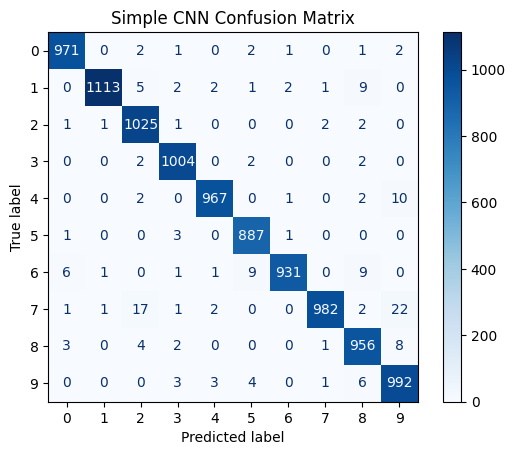

In [ ]:
# --- 1. Evaluate on Test Set ---
model_cnn.eval()  # Set model to evaluation mode
y_pred_list_cnn = []
y_true_list_cnn = []

start_time = time.time()
with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in cnn_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_cnn(inputs)

        _, predicted = torch.max(outputs.data, 1)

        y_pred_list_cnn.extend(predicted.cpu().numpy())
        y_true_list_cnn.extend(labels.cpu().numpy())

# --- Calculate Inference Time ---
end_time = time.time()
cnn_inference_time = end_time - start_time
print(f"Simple CNN Inference Time: {cnn_inference_time:.4f} seconds")

# --- 2. Calculate Metrics ---
y_pred_cnn = np.array(y_pred_list_cnn)
y_true_cnn = np.array(y_true_list_cnn)

cnn_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted')

print(f"\n--- Simple CNN Performance ---")
print(f"Accuracy: {cnn_accuracy:.4f}")
print(f"F1-Score (Weighted): {cnn_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_cnn, y_pred_cnn))

# --- 3. Get Model Size ---
# This function iterates over all parameters and sums them up
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cnn_params = count_parameters(model_cnn)
print(f"\nModel Size (Trainable Parameters): {cnn_params:,}")


# --- 4. Plot Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Simple CNN Confusion Matrix")
plt.show()

In [ ]:
# --- Define Transform for Pretrained Models ---
# EfficientNetB0 was trained on 224x224
# MobileNetV2 was trained on 224x224 (but can handle smaller, min 32x32)
# We'll use 72x72 as a compromise.
IMG_SIZE = 72

# Normalize using ImageNet mean and std for all 3 channels
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform_pretrained = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 1. Resize to 72x72
    transforms.Grayscale(num_output_channels=3), # 2. Convert 1-channel to 3-channel
    transforms.ToTensor(), # 3. Convert to tensor [3, 72, 72]
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std) # 4. Normalize
])

# --- Create New Datasets and DataLoaders ---
# We use the *original* datasets, but apply the *new* transform
train_dataset_pre = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_pretrained # Apply the new transform
)

test_dataset_pre = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_pretrained # Apply the new transform
)

pre_train_loader = DataLoader(
    dataset=train_dataset_pre,
    batch_size=BATCH_SIZE,
    shuffle=True
)

pre_test_loader = DataLoader(
    dataset=test_dataset_pre,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"DataLoaders for pretrained models created.")
# Let's check the shape of one batch
data, labels = next(iter(pre_train_loader))
print(f"Data batch shape: {data.shape}") # Should be [BATCH_SIZE, 3, 72, 72]

DataLoaders for pretrained models created.
Data batch shape: torch.Size([64, 3, 72, 72])


In [ ]:
from torchvision import models

def train_pretrained_model(model_name, num_epochs=5):
    """
    Loads, adapts, trains, and evaluates a pretrained model on MNIST.
    """
    print(f"\n--- Loading {model_name} ---")

    # --- 1. Load Model ---
    if model_name == 'MobileNetV2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        # Freeze base layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace classifier
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, 10)

    elif model_name == 'EfficientNetB0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Freeze base layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace classifier
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, 10)
    else:
        raise ValueError("Model name not recognized")

    model = model.to(device)

    # --- 2. Train the New Classifier ---
    criterion = nn.CrossEntropyLoss()
    # We only optimize the parameters of the new classifier
    # (which have requires_grad=True by default)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Starting {model_name} training (transfer learning)...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(pre_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1} finished, Loss: {running_loss/len(pre_train_loader):.4f}")

    print(f"{model_name} training finished.")

    # --- 3. Evaluate the Model ---
    model.eval()
    y_pred_list = []
    y_true_list = []

    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in pre_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())
    end_time = time.time()

    # --- 4. Get Metrics ---
    y_pred = np.array(y_pred_list)
    y_true = np.array(y_true_list)

    metrics = {
        'model_name': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred, average='weighted'),
        'params': count_parameters(model), # Counts only *trainable* params
        'total_params': sum(p.numel() for p in model.parameters()), # Counts all params
        'inference_time': end_time - start_time,
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1-Score (Weighted): {metrics['f1_score']:.4f}")
    print(f"Inference Time: {metrics['inference_time']:.4f} seconds")
    print(f"Trainable Parameters: {metrics['params']:,}")
    print(f"Total Parameters: {metrics['total_params']:,}")

    return metrics

In [ ]:
# --- Run for MobileNetV2 ---
# (Using 5 epochs for transfer learning)
mobilenet_results = train_pretrained_model('MobileNetV2', num_epochs=5)

# --- Run for EfficientNetB0 ---
efficientnet_results = train_pretrained_model('EfficientNetB0', num_epochs=5)


--- Loading MobileNetV2 ---
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 203MB/s]

Starting MobileNetV2 training (transfer learning)...


Epoch 1/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 finished, Loss: 0.4220


Epoch 2/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 finished, Loss: 0.3040


Epoch 3/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 finished, Loss: 0.2934


Epoch 4/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 finished, Loss: 0.2866


Epoch 5/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 finished, Loss: 0.2811
MobileNetV2 training finished.
--- MobileNetV2 Performance ---
Accuracy: 0.9349
F1-Score (Weighted): 0.9347
Inference Time: 6.7709 seconds
Trainable Parameters: 12,810
Total Parameters: 2,236,682

--- Loading EfficientNetB0 ---
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 210MB/s]

Starting EfficientNetB0 training (transfer learning)...


Epoch 1/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 finished, Loss: 0.6581


Epoch 2/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 finished, Loss: 0.5006


Epoch 3/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 finished, Loss: 0.4763


Epoch 4/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 finished, Loss: 0.4732


Epoch 5/5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 finished, Loss: 0.4687
EfficientNetB0 training finished.
--- EfficientNetB0 Performance ---
Accuracy: 0.8919
F1-Score (Weighted): 0.8916
Inference Time: 7.2850 seconds
Trainable Parameters: 12,810
Total Parameters: 4,020,358




--- FINAL MODEL COMPARISON ---
| model_name     |   accuracy |   f1_score |   total_params |   inference_time |
|:---------------|-----------:|-----------:|---------------:|-----------------:|
| SimpleCNN      |     0.9828 |   0.982808 |         693962 |          1.87661 |
| MobileNetV2    |     0.9349 |   0.93474  |        2236682 |          6.77088 |
| EfficientNetB0 |     0.8919 |   0.891634 |        4020358 |          7.28498 |


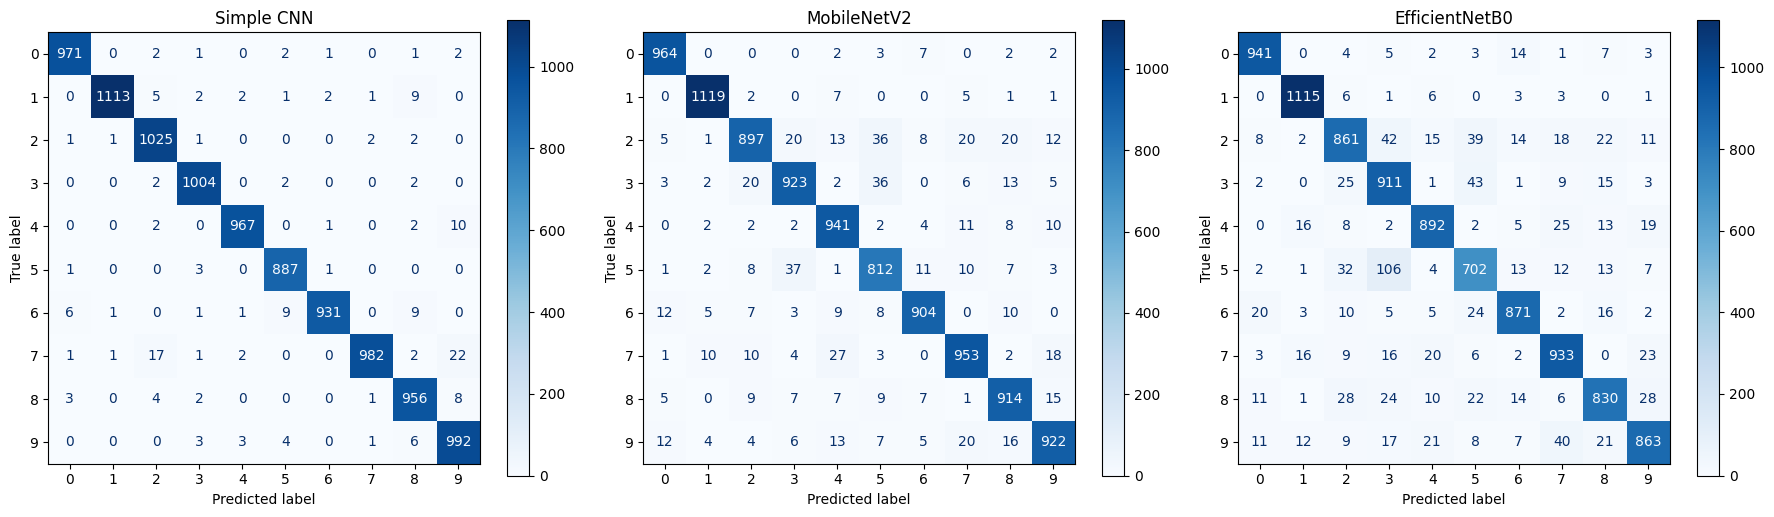

In [ ]:
# --- Collect Simple CNN results ---
cnn_results = {
    'model_name': 'SimpleCNN',
    'accuracy': cnn_accuracy,
    'f1_score': cnn_f1,
    'total_params': cnn_params, # For our simple CNN, total params = trainable params
    'inference_time': cnn_inference_time,
    'confusion_matrix': confusion_matrix(y_true_cnn, y_pred_cnn)
}

# --- Create Final Comparison DataFrame ---
all_results = [
    cnn_results,
    mobilenet_results,
    efficientnet_results
]

# We want to see total params for model size, not just trainable params
comparison_df = pd.DataFrame(all_results, columns=[
    'model_name',
    'accuracy',
    'f1_score',
    'total_params',
    'inference_time'
])

print("\n\n--- FINAL MODEL COMPARISON ---")
print(comparison_df.to_markdown(index=False))

# --- Plot all Confusion Matrices ---
plt.figure(figsize=(18, 5))

# Plot 1: Simple CNN
plt.subplot(1, 3, 1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cnn_results['confusion_matrix'])
disp1.plot(ax=plt.gca(), cmap=plt.cm.Blues)
plt.title("Simple CNN")

# Plot 2: MobileNetV2
plt.subplot(1, 3, 2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=mobilenet_results['confusion_matrix'])
disp2.plot(ax=plt.gca(), cmap=plt.cm.Blues)
plt.title("MobileNetV2")

# Plot 3: EfficientNetB0
plt.subplot(1, 3, 3)
disp3 = ConfusionMatrixDisplay(confusion_matrix=efficientnet_results['confusion_matrix'])
disp3.plot(ax=plt.gca(), cmap=plt.cm.Blues)
plt.title("EfficientNetB0")

plt.tight_layout()
plt.show()